In [3]:
from __future__ import print_function
import torch
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import copy

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Set desired rectangular size
imsize = (256, 370) 

# Define transformation to resize and convert images to tensors
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)  # Add batch dimension
    return image.to(device, torch.float)

def save_image(tensor, path):
    unloader = transforms.ToPILImage()  # Reconvert tensor to PIL image
    image = tensor.cpu().clone()  # Clone tensor to avoid modifying original
    image = image.squeeze(0)  # Remove batch dimension
    image = unloader(image)
    image.save(path)


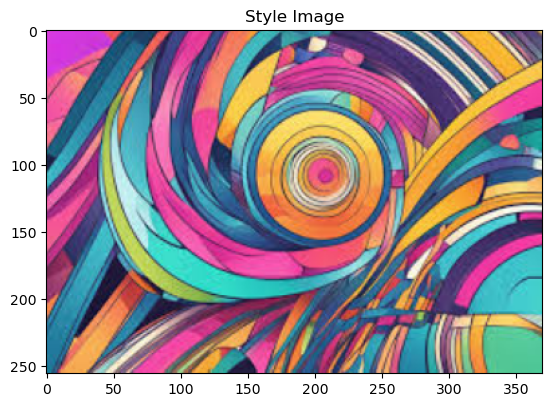

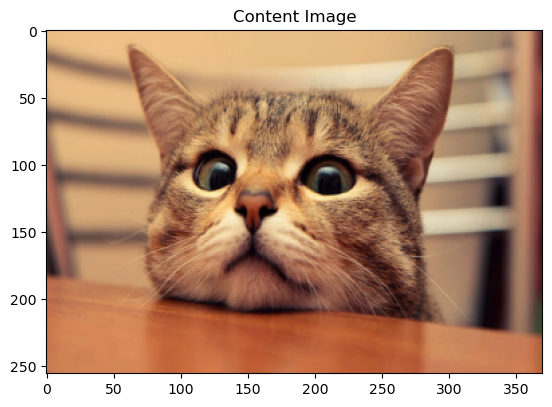

In [6]:
style_img = image_loader("/Users/gurnoorkhurana/Documents/GitHub/NST_Project/style/images-8.jpeg")
content_img = image_loader("/Users/gurnoorkhurana/Documents/GitHub/NST_Project/content/cat-animals-bokeh-cute-wallpaper-preview.jpg")
# Ensure images are the same size
assert style_img.size() == content_img.size(), \
    "Style and content images should now have the same size."

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x, self.target)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def gram_matrix(self, x):
        a, b, c, d = x.size()
        features = x.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)

    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = F.mse_loss(G, self.target)
        return x


In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Deep copy of VGG model to add content and style loss layers
cnn = copy.deepcopy(cnn)


/opt/anaconda3/envs/tf_38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/tf_38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
def get_style_model_and_losses(cnn, style_img, content_img):
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # Sequential model to add layers dynamically

    i = 0  # Index to keep track of conv layers
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim layers after the last style and content loss layers
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses


In [10]:
# Use the content image as the initial input
input_img = content_img.clone()

# Style and content weights for balanced results
style_weight = 1e7
content_weight = 1e1

# Define optimizer with lower learning rate
optimizer = optim.LBFGS([input_img.requires_grad_()], lr=0.5)


In [11]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=1000,
                       style_weight=style_weight, content_weight=content_weight):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)

    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)  # Clamp to [0, 1] to prevent color saturation

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run [{run[0]}]: Style Loss : {style_score.item():.4f} Content Loss: {content_score.item():.4f}")

            return style_score + content_score

        optimizer.step(closure)

    # Clamp to maintain color range
    input_img.data.clamp_(0, 1)
    return input_img


run [50]: Style Loss : 186.6792 Content Loss: 80.6231
run [100]: Style Loss : 30.6673 Content Loss: 77.9234
run [150]: Style Loss : 11.1148 Content Loss: 72.5413
run [200]: Style Loss : 7.7012 Content Loss: 68.2048
run [250]: Style Loss : 6.0265 Content Loss: 64.7674
run [300]: Style Loss : 5.2050 Content Loss: 62.1923
run [350]: Style Loss : 4.6425 Content Loss: 60.3219
run [400]: Style Loss : 4.3893 Content Loss: 58.8372
run [450]: Style Loss : 4.1377 Content Loss: 57.8491
run [500]: Style Loss : 4.1256 Content Loss: 57.0126
run [550]: Style Loss : 3.9348 Content Loss: 56.5287
run [600]: Style Loss : 3.8540 Content Loss: 56.0039
run [650]: Style Loss : 3.8170 Content Loss: 55.7217
run [700]: Style Loss : 4.2193 Content Loss: 55.5636
run [750]: Style Loss : 21.1748 Content Loss: 56.3215
run [800]: Style Loss : 3.7664 Content Loss: 55.0433
run [850]: Style Loss : 3.8114 Content Loss: 55.2418
run [900]: Style Loss : 4.0346 Content Loss: 55.3909
run [950]: Style Loss : 3.9943 Content Los

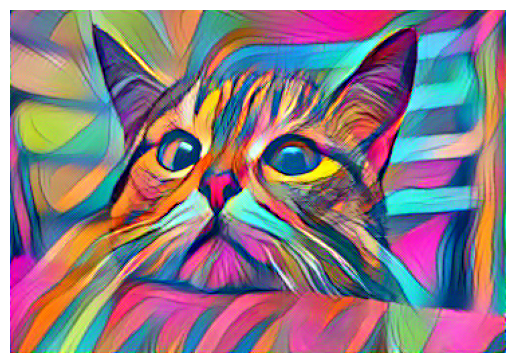

In [12]:
# Run the style transfer and get the output image
output = run_style_transfer(cnn, content_img, style_img, input_img)

# Convert the output tensor to a format that can be displayed
output_img = output.cpu().clone().squeeze(0)  # Remove batch dimension
output_img = transforms.ToPILImage()(output_img)

# Display the image
plt.figure()
plt.imshow(output_img)
plt.axis("off")  # Hide axes for a cleaner display
plt.show()
